In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## Questão 1

In [12]:
df_quake = pd.read_csv('data/quake.csv')
df_quake.columns = ['lat', 'long']
df_quake.head()

,lat,long
0,45.53,150.93
1,41.85,142.78
2,29.19,141.15
3,-21.66,169.81
4,23.09,120.58


A função a seguir repete a execução do KMeans $n$ vezes e retorna o modelo com o melhor erro de reconstrução, o qual pode ser calculado por:
$$
\mathcal{J}(\mathcal{C}) = \sum_{k = 1}^K \sum_{\boldsymbol{x}_i \in C_k} ||\boldsymbol{x}_i - \boldsymbol{m}_k||^2,
$$
Onde:
- $\boldsymbol{m}_k$ são os centróides do k-ésimo cluster;
- e $C_k$ são as partições.

OBS: o Scikit trata ele como inércia.

In [13]:
def run_kmeans_best_of_n(X, k, n_repeats=20, max_iter=300, random_state=0):
    best_model = None
    best_inertia = np.inf

    for r in range(n_repeats):
        km = KMeans(
            n_clusters=k,
            init='k-means++',
            n_init=1,              # controlamos a repetição fora do loop
            max_iter=max_iter,
            random_state=random_state + r,
            algorithm='lloyd'      # utiliza o algoritmo de Lloyd (padrão)
        )
        km.fit(X)

        if km.inertia_ < best_inertia:
            best_inertia = km.inertia_
            best_model = km

    return best_model, best_inertia

O índice Davies-Bouldin (DB) é computado como:
$$
\text{DB}(\mathcal{C}) = \frac{1}{K} \sum_{k = 1}^K \max_{k' \neq k} \left( \frac{\delta_k + \delta_{k'}}{\Delta_{kk'}} \right),
$$
Onde:
- $\delta_k$ é o espalhamento intra-agrupamento;
- e $\Delta_k$ é o  espalhamento entre grupos.

Além disso,
$$
\delta_k = \frac{1}{N_k} \sum_{\boldsymbol{x} \in C_k} ||\boldsymbol{x}_n - \boldsymbol{m}_k||,
$$
$$
\Delta_{kk'} = ||\boldsymbol{m}_k - \boldsymbol{m}_{k'}||,
$$
$$
\boldsymbol{m}_k = \frac{1}{N_k} \sum_{\boldsymbol{x} \in C_k} \boldsymbol{x}_i.
$$

In [14]:
def davies_bouldin_custom(X, labels, metric='euclidean', inv=None):
    X = np.asarray(X, float)
    labels = np.asarray(labels)
    clusters = np.unique(labels)
    k = len(clusters)
    if k < 2:
        raise ValueError('DB precisa de, pelo menos, 2 clusters.')

    # Cria uma matriz (n_clusters, n_features) que calcula os valores dos centróides
    # de cada cluster a partir da média dos valores
    centroids = np.vstack([X[labels == c].mean(axis=0) for c in clusters])

    def dist(a, b):
        d = a - b
        if metric == 'euclidean':
            return np.sqrt(np.dot(d, d))
        elif metric == 'mahalanobis':
            if inv is None:
                raise ValueError('Para Mahalanobis, forneça a matriz de covariância inversa')
            return np.sqrt(d @ inv @ d)
        else:
            raise ValueError('Métrica inválida')

    # delta_k: média das distâncias dos pontos ao centróide do cluster k
    deltas = np.zeros(k)
    for i, c in enumerate(clusters):
        Xi = X[labels == c]
        if Xi.shape[0] == 0:
            raise ValueError('Cluster vazio.')
        deltas[i] = np.mean([dist(x, centroids[i]) for x in Xi])

    # D: distâncias entre centróides
    D = np.zeros((k, k))
    for i in range(k):
        for j in range(i + 1, k):
            D[i, j] = D[j, i] = dist(centroids[i], centroids[j])

    Rmax = np.zeros(k)
    for i in range(k):
        ratios = []
        for j in range(k):
            if i == j:
                continue
            if D[i, j] == 0:
                ratios.append(np.inf)
            else:
                ratios.append((deltas[i] + deltas[j]) / D[i, j])
        Rmax[i] = np.max(ratios)

    return np.mean(Rmax)

In [15]:
def plot_clusters(X, labels, centroids, title, xlabel="long", ylabel="lat"):
    plt.figure(figsize=(7, 6))
    plt.scatter(X[:, 1], X[:, 0], c=labels, s=18, alpha=0.75)
    plt.scatter(centroids[:, 1], centroids[:, 0], c="black", s=120, marker="X")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.25)
    plt.show()

### Distância euclidiana

=== (a) Euclidiano: resultados por k ===
     k  db_euclid     inertia
16  20   0.568953   76.636717
11  15   0.584838  112.538964
8   12   0.590383  157.041616
6   10   0.591239  211.364562
15  19   0.592025   81.612871
10  14   0.592255  123.045726
14  18   0.593779   89.005595
9   13   0.596555  139.471822
12  16   0.596637  104.380149
13  17   0.600595   96.020603

Melhor k (Euclidiano) = 20 | DB = 0.568953 | inertia = 76.636717


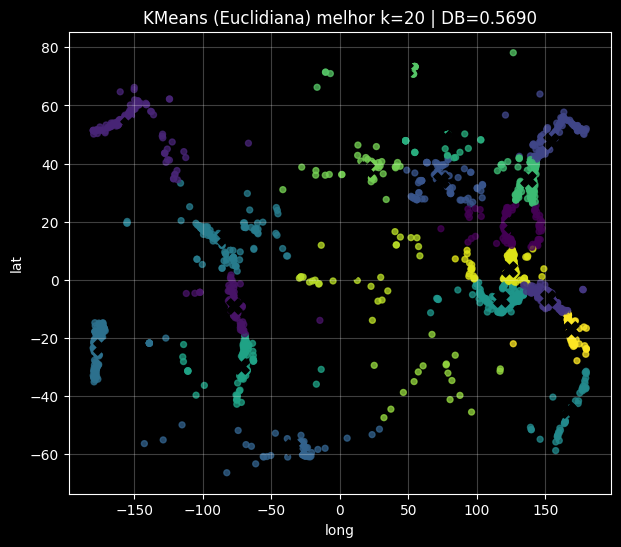

In [16]:
X_raw = df_quake[['lat', 'long']].to_numpy(dtype=float)
X = X_raw.copy()

scaler_euc = StandardScaler()
X = scaler_euc.fit_transform(X)

k_values = list(range(4, 21))
n_repeats = 20

results_euc = []
best_overall_euc = None  # (db, k, model, inercia)

for k in k_values:
    model, inertia = run_kmeans_best_of_n(X, k, n_repeats=n_repeats, random_state=12345)
    labels = model.labels_
    db = davies_bouldin_custom(X, labels, metric='euclidean')
    results_euc.append((k, db, inertia))

    if best_overall_euc is None or db < best_overall_euc[0]:
        best_overall_euc = (db, k, model, inertia)

results_euc = pd.DataFrame(results_euc, columns=["k", "db_euclid", "inertia"])
print("=== (a) Euclidiano: resultados por k ===")
print(results_euc.sort_values("db_euclid").head(10))

best_db, best_k, best_model, best_inertia = best_overall_euc
print(f"\nMelhor k (Euclidiano) = {best_k} | DB = {best_db:.6f} | inertia = {best_inertia:.6f}")

# Plot do melhor agrupamento (em escala original)
labels_best = best_model.labels_
centroids_best = scaler_euc.inverse_transform(best_model.cluster_centers_)
plot_clusters(
    X_raw,
    labels_best,
    centroids_best,
    title=f"KMeans (Euclidiana) melhor k={best_k} | DB={best_db:.4f}",
    xlabel="long", ylabel="lat"
)

### Distância de Mahalanobis
A implementação do KMeans no Scikit-Learn não suporta diretamente a distância de Mahalanobis. Portanto, será usada uma transformação linear dos dados para que a distância euclidiana no novo espaço transformado ($Z$) corresponda à distância de Mahalanobis no original ($X_{\text{raw}}$).

Por definição, $d_M(\boldsymbol{x}_i, \boldsymbol{x}_j)^2 = (\boldsymbol{x}_i - \boldsymbol{x}_j)^T \boldsymbol{\Sigma}^{-1} (\boldsymbol{x}_i - \boldsymbol{x}_j)$. Observe que $\Sigma^{-1} = \Sigma^{-1/2} \Sigma^{-1/2}$, de forma que a transformação linear é dada por $\boldsymbol{z} = \boldsymbol{\Sigma}^{-1/2} \boldsymbol{x}$.

Além disso, $\boldsymbol{\Sigma}^{-1} = \boldsymbol{V} \boldsymbol{\Lambda}^{-1} \boldsymbol{V}^T$, onde $\boldsymbol{V}$ é a matriz dos autovetores e $\boldsymbol{\Lambda}$ é a matriz diagonal dos autovalores de $\boldsymbol{\Sigma}$. Portanto, $\boldsymbol{\Sigma}^{-1/2} = \boldsymbol{V} \boldsymbol{\Lambda}^{-1/2} \boldsymbol{V}^T$.

In [17]:
X_raw = df_quake[['lat', 'long']].to_numpy(float)

Sigma = np.cov(X_raw, rowvar=False)
lam = 1e-8                                                        # termo para estabilidade numérica
Sigma_reg = Sigma + lam * np.eye(Sigma.shape[0])

# Decomposição espectral para matriz simétrica
evals, evecs = np.linalg.eigh(Sigma_reg)
L = np.linalg.cholesky(Sigma_reg)                                 # inv = L @ L.T

# Definição de um piso numérico para os autovalores
# A fim de evitar divisões por zero ou instabilidades numéricas
eps = 1e-12
evals = np.maximum(evals, eps)

# Cálculo da matriz de covariância inversa usando os autovalores e autovetores
Sigma_inv_sqrt = evecs @ np.diag(1.0 / np.sqrt(evals)) @ evecs.T  # Sigma^(-1/2)
Sigma_sqrt = evecs @ np.diag(np.sqrt(evals)) @ evecs.T            # Sigma^(1/2)
inv = Sigma_inv_sqrt @ Sigma_inv_sqrt                             # Sigma^(-1)

Z = X_raw @ Sigma_inv_sqrt                                        # transformação linear dos dados

=== (b) Mahalanobis: resultados por k ===
     k  db_mahalanobis     inertia
13  17        0.572670   97.021826
10  14        0.573988  123.118970
8   12        0.575496  159.102589
9   13        0.577406  140.262505
0    4        0.588540  759.737675
11  15        0.588939  113.130702
12  16        0.591177  104.795857
14  18        0.593468   92.558119
7   11        0.603833  185.126284
16  20        0.604655   76.857852

Melhor k (Mahalanobis) = 17 | DB = 0.572670 | inertia = 97.021826


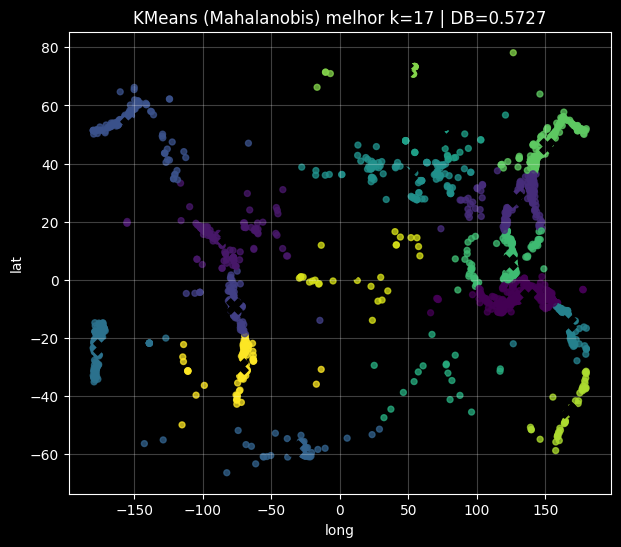

In [18]:
results_mh = []
best_overall_mh = None # (db, k, model, inercia)

for k in k_values:
    model, inertia = run_kmeans_best_of_n(Z, k, n_repeats=n_repeats, random_state=12345)
    labels = model.labels_
    db = davies_bouldin_custom(X_raw, labels, metric='mahalanobis', inv=inv)
    results_mh.append((k, db, inertia))

    if best_overall_mh is None or db < best_overall_mh[0]:
        best_overall_mh = (db, k, model, inertia)

results_mh = pd.DataFrame(results_mh, columns=["k", "db_mahalanobis", "inertia"])
print("=== (b) Mahalanobis: resultados por k ===")
print(results_mh.sort_values("db_mahalanobis").head(10))

best_db, best_k, best_model, best_inertia = best_overall_mh
print(f"\nMelhor k (Mahalanobis) = {best_k} | DB = {best_db:.6f} | inertia = {best_inertia:.6f}")

# Destransformar os centróides antes da plotagem
centroids_Z = best_model.cluster_centers_
centroids_raw = centroids_Z @ Sigma_sqrt

plot_clusters(
    X_raw,
    best_model.labels_,
    centroids_raw,
    title=f"KMeans (Mahalanobis) melhor k={best_k} | DB={best_db:.4f}",
    xlabel="long", ylabel="lat"
)

## Questão 2

In [18]:
df_penguins = pd.read_csv('data/penguins.csv')
df_penguins.head()

,3.910000000000000142e+01,1.869999999999999929e+01,1.810000000000000000e+02,3.750000000000000000e+03,0.000000000000000000e+00
0,39.5,17.4,186.0,3800.0,0.0
1,40.3,18.0,195.0,3250.0,0.0
2,36.7,19.3,193.0,3450.0,0.0
3,39.3,20.6,190.0,3650.0,0.0
4,38.9,17.8,181.0,3625.0,0.0


In [19]:
X_raw_penguins = df_penguins.iloc[:, :-1].to_numpy(dtype=float)
y_raw_penguins = df_penguins.iloc[:, -1].to_numpy()

In [20]:
scaler_penguins = StandardScaler()
X_penguins = scaler_penguins.fit_transform(X_raw_penguins)

A matriz de covariância dos dados pode ser decomposta como:
$$
\boldsymbol{M} = \boldsymbol{U} \boldsymbol{S} \boldsymbol{V}^T,
$$
Onde, para uma matriz quadrada:
- $\boldsymbol{U}$ são os autovetores da matriz;
- $\boldsymbol{S}$ é a matriz diagonal dos autovalores;
- e $\boldsymbol{V}^T$ é a transposta da matriz dos autovetores ($\boldsymbol{U} = \boldsymbol{V}$).

Os componentes principais são as colunas de $\boldsymbol{U}$. Elas formarão as linhas da matriz de projeção $\boldsymbol{P}$. Portanto, a projeção linear dos dados é dada por:
$$
\boldsymbol{z}_i = \boldsymbol{P}\boldsymbol{x}_i = \boldsymbol{U}^T \boldsymbol{x}_i, \quad \boldsymbol{x}_i |_{i = 1}^N.
$$

In [21]:
# Matriz de covariância (D, D) quadrada e simétrica
M = np.cov(X_penguins, rowvar=False)

U, S, Vt = np.linalg.svd(M, full_matrices=False)

components = Vt.T      # (D, D) se D <= N

# Projeção em 2D
Z_2d = X_penguins @ components[:, :2]

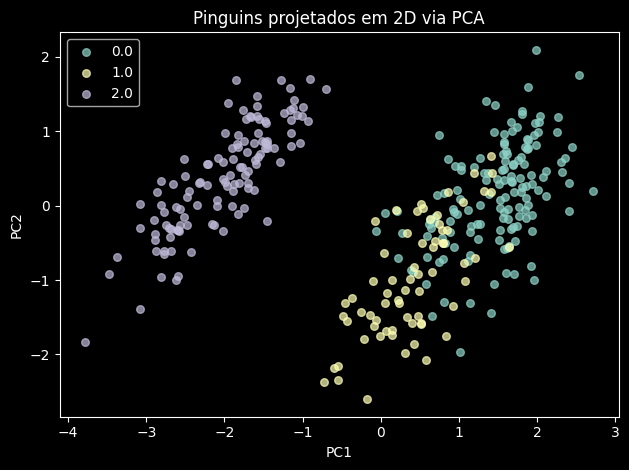

In [22]:
species = np.unique(y_raw_penguins)

for sp in species:
    idx = (y_raw_penguins == sp)
    plt.scatter(Z_2d[idx, 0], Z_2d[idx, 1],
                label=str(sp), alpha=0.7, s=30)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('Pinguins projetados em 2D via PCA')
plt.tight_layout()
plt.show()

In [23]:
explained_variance = S / np.sum(S)
explained_variance_pct = explained_variance * 100

cumulative_variance = explained_variance.cumsum() * 100
for i, (e, c) in enumerate(zip(explained_variance_pct, cumulative_variance), start=1):
    print(f"PC{i}: {e:.2f}% (acumulada: {c:.2f}%)")

PC1: 68.59% (acumulada: 68.59%)
PC2: 19.49% (acumulada: 88.08%)
PC3: 9.23% (acumulada: 97.31%)
PC4: 2.69% (acumulada: 100.00%)
